# $\Phi$-SO demo : Encoding and decoding expressions

This notebook demonstrates how to numerically encode and decode mathematical expressions using `physo.toolkit`. This is useful for any machine learning (ML) tasks that involves symbolic mathematical expressions, such as symbolic regression, equation discovery, or any task that requires the manipulation of mathematical formulas.

We will also give a generic for loop that you can use to insert your own generative ML model to generate expressions that satisfy any criteria you may have while ensuring that the generated expressions are valid and can be decoded back to their symbolic form.

Key features include:
- 🧠 __Priors__ : `physo` includes many deterministic priors that are computed after each token generation that can be used to e.g. bias the search towards certain expressions : this includes length priors, structural priors (e.g. excluding nesting of trigonometric functions such as $\text{cos}(a+\text{sin}(1/\text{tan}(x)))$), dimensional analysis priors, prior about the number of occurrences of a token, prior about sub-functions, and more.
- 📦 __Flexible export__: Expressions can be exported to various formats including (differentiable) python functions, SymPy objects, LaTeX, strings and saved on disk.
- ⚡️ __Evaluation and parameter fitting__: Expressions can be numerically evaluated, and their free parameters optimized as needed (in parallel across a batch of equations if desired). Uncertainty can also be taken into account via weights.
- 🔢 __Encoding__: Expressions' numerical encoding can be accessed easily, facilitating the use of expressions for machine learning purposes.
- ⛓️ __Auto-differentiable structures__: Expression trees are compatible with automatic differentiation.
- 🌳 __Tree structure navigation__: The expression tree can be displayed and navigated. This can be used to access e.g. parent, children, and sibling nodes of any token, and even list their ancestors in a vectorized way across all expressions in the batch.
- ⚖️ __Physical Units information__: Physical units of each token is dynamically computed and stored in the expression tree.
- 📚 __One equation, multiple datasets__: Expressions can contain dataset-specific free constant values through, allowing for a single equation to be evaluated and fitted across multiple datasets.


This notebook is complemented by a second notebook that shows how to manipulate the symbolic expressions, including inspecting, showing, exporting, evaluating, and more. See [demo_expressions](https://github.com/WassimTenachi/PhySO/blob/dev-enc/demos/toolkit/demo_expressions.ipynb).

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import warnings

In [32]:
# Internal code import
import physo

Fixing seed

In [33]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

### Vocabulary : Library of choosable tokens

In computational symbolic mathematics, tokens encoded as integers are used to represent mathematical symbols (variables, constants, operations, etc.).

This is akin to how words (or more often sub-words) are encoded as integers in natural language processing. The set of all tokens that can be chosen from is called the vocabulary, and is stored in a library. With the differences that here tokens are intrinsically different from one another in the number of arguments they take : their arity.

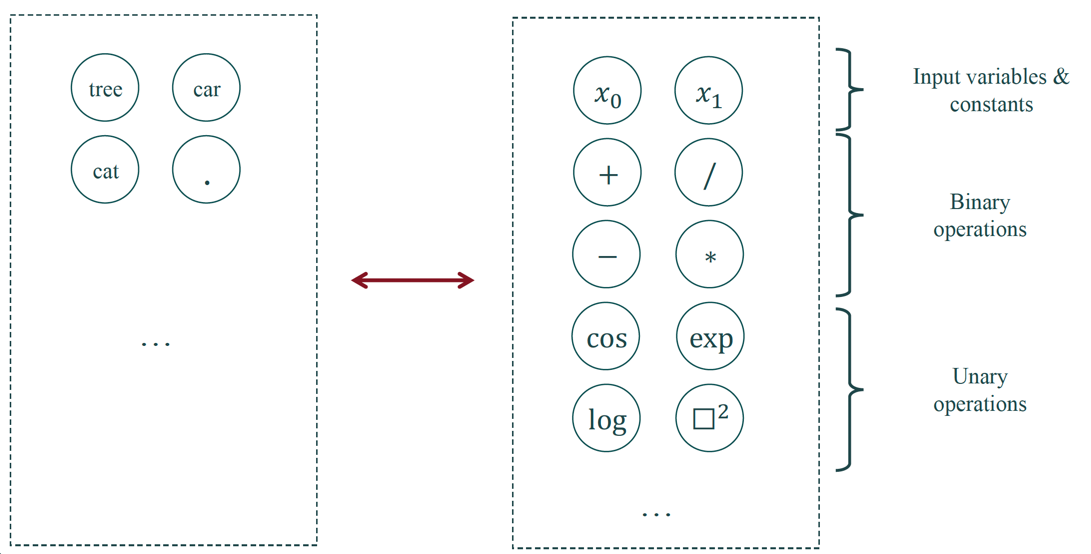

Here we will use 6 input variables ($x_1, x_2, x_3, x_4, x_5, x_6$)  along with a fixed constant $1$ and two free constants $a, b$. We will also use a set of operations that includes addition, subtraction, multiplication, division, power, logarithm, exponential, and cosine to make up our library.

In [34]:
my_library = physo.toolkit.get_library(
        X_names = ["x1", "x2", "x3", "x4", "x5", "x6",],
        # y
        y_name = "y",
        # Fixed constants
        fixed_consts       = [1.],
        # Free constants
        free_consts_names = ["a", "b"],
        # Operations to use
        op_names = ["add", "sub", "mul", "div", "pow", "log", "exp", "cos"],
)

Let's show tokens that can be chosen from this library.

In [35]:
# Tokens
print(my_library.choosable_tokens)

[add, sub, mul, div, pow, log, exp, cos, 1.0, a, b, x1, x2, x3, x4, x5, x6]


In [36]:
# Inspecting a token
my_token = my_library.choosable_tokens[5]
print(my_token)
print(f"{my_token} takes {my_token.arity} arguments")

log
log takes 1 arguments


Tokens are each encodec with a unique index, which is used to encode the expression as a vector of integers. The encoding indices are stored in the library.

In [37]:
# names -> idx : Dictionary of choosable token names to their encoding indices
my_library.choosable_name_to_idx

{np.str_('add'): 0,
 np.str_('sub'): 1,
 np.str_('mul'): 2,
 np.str_('div'): 3,
 np.str_('pow'): 4,
 np.str_('log'): 5,
 np.str_('exp'): 6,
 np.str_('cos'): 7,
 np.str_('1.0'): 8,
 np.str_('a'): 9,
 np.str_('b'): 10,
 np.str_('x1'): 11,
 np.str_('x2'): 12,
 np.str_('x3'): 13,
 np.str_('x4'): 14,
 np.str_('x5'): 15,
 np.str_('x6'): 16}

In [38]:
# idx -> names : in order to decode the indices back to names, we can the names from the library
my_library.choosable_names

array(['add', 'sub', 'mul', 'div', 'pow', 'log', 'exp', 'cos', '1.0', 'a',
       'b', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6'], dtype='<U3')

The vocabulary size i.e. the number of tokens that can be chosen from is given by:

In [39]:
vocab_size = my_library.vocab_size

A list of all currently available operations in `physo` (e.g. mul, add, cos, exp etc.) can be shown using:

In [40]:
physo.physym.functions.OPS_NAMES

['add',
 'sub',
 'mul',
 'div',
 'sin',
 'cos',
 'tan',
 'exp',
 'log',
 'sqrt',
 'cbrt',
 'n2',
 'neg',
 'abs',
 'inv',
 'tanh',
 'sinh',
 'cosh',
 'arctan',
 'arccos',
 'arcsin',
 'erf',
 'logabs',
 'expneg',
 'n3',
 'n4',
 'pow']

## Encoding mathematical expressions

In computational symbolic mathematics, mathematical expressions are often represented as trees, where each node is a token (e.g. an operation or a variable). As illustrated below, by listing the tokens first in depth and then left to right, we write expressions in so-called prefix notation (also known as Polish notation), alleviating the need for parentheses to indicate the order of operations. As other symbolic mathematics packages, `physo` uses this notation to encode expressions as vectors of tokens e.g. vector of integers.

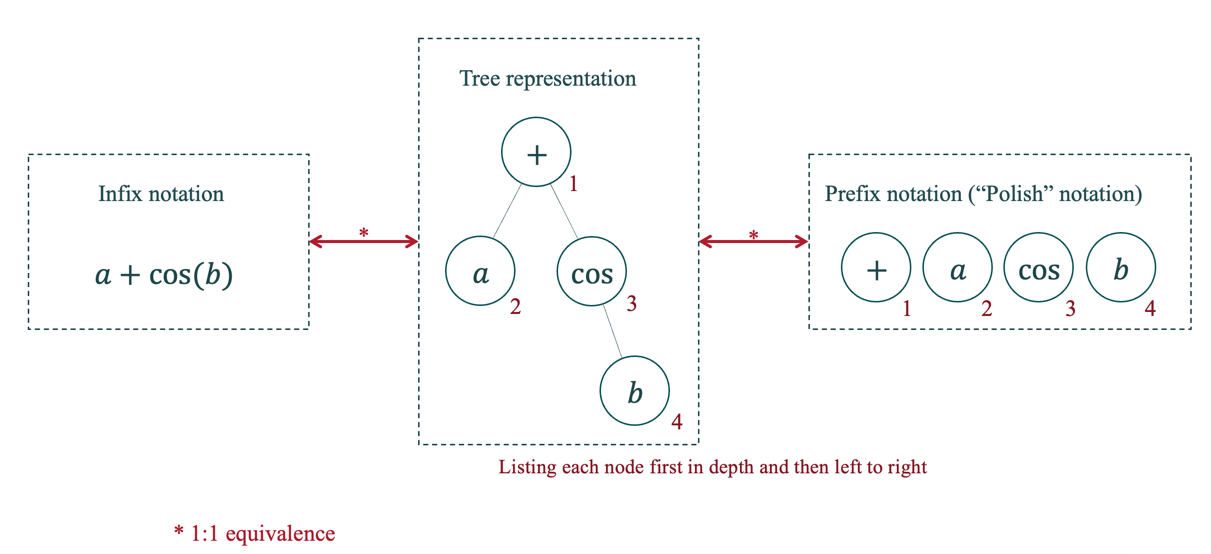

### Encoding from prefix notation

Let's encode two simple expressions :
- $a+\text{cos}(b)$
- $\text{log}(x_1+x_2)+\text{exp}(x_3)$

In [41]:
# a+cos(b) in prefix notation
expr1_str = ["add", "a", "cos", "b"]
# log(x1+x2)+exp(x3) in prefix notation
expr2_str = ["add", "log", "add", "x1", "x2", "exp", "x3"]

In [42]:
# Encoding the expressions
expressions_enc = my_library.encode([expr1_str,expr2_str])
expr1_enc = expressions_enc[0]
expr2_enc = expressions_enc[1]
print(expr1_enc)
print(expr2_enc)

[0, 9, 7, 10]
[0, 5, 0, 11, 12, 6, 13]


Expressions can further be encoded in a one-hot format, where each token is represented by a vector of zeros of size (vocab_size,) with a single one at the index corresponding to the token's encoding index. This is useful for machine learning tasks, as it essentially represents the expression as a set of probability distributions over the vocabulary of tokens (with 100% probability on the chosen token and 0% on all others).

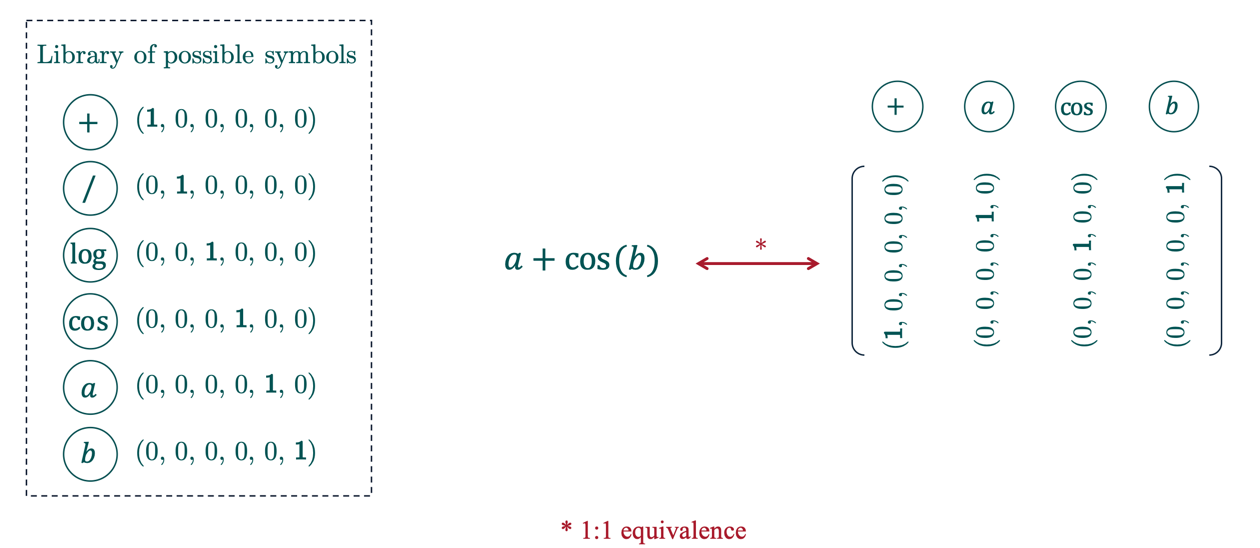
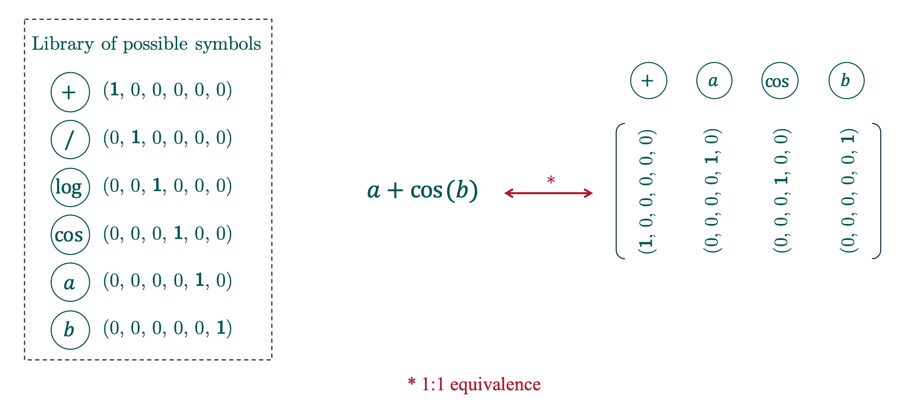
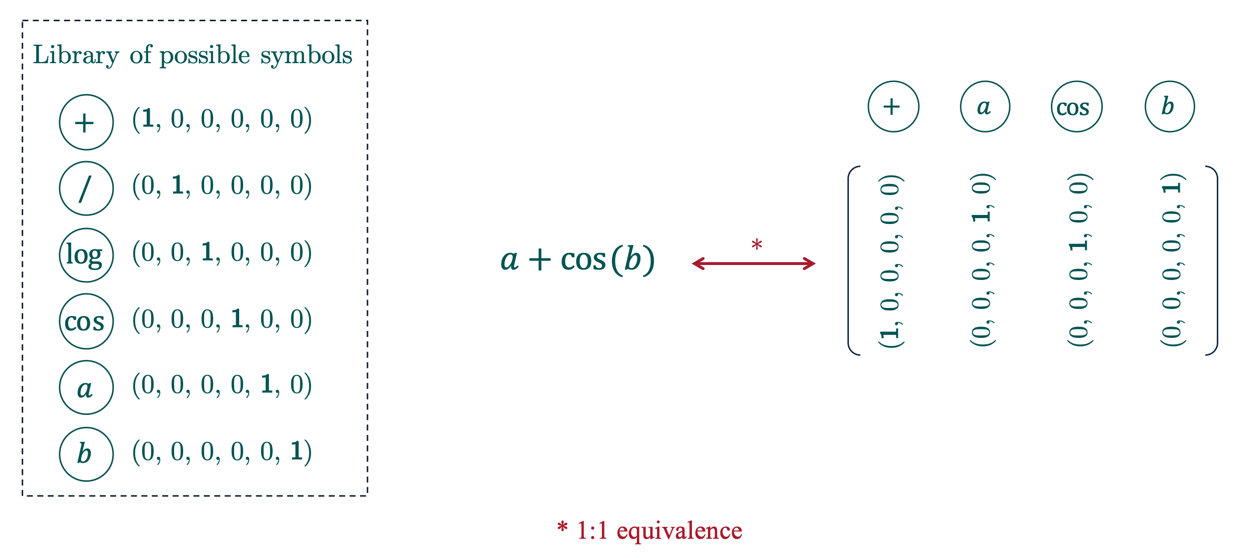

### One-hot encoding

In [43]:
expressions_one_hot = my_library.encode([expr1_str,expr2_str], one_hot=True)
expr1_one_hot = expressions_one_hot[0]
expr2_one_hot = expressions_one_hot[1]

print(expr1_one_hot.shape)
print(expr1_one_hot)
print(expr2_one_hot.shape)
print(expr2_one_hot)

(4, 17)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
(7, 17)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


## Decoding completed symbolic expressions

Encoded expressions can be decoded back to `physo` expressions, facilitating their manipulation : accessing symbolic information, evaluating them, differentiating them, and more.

----
The following shows how to proceed in cases where expressions are already correct mathematically. See the decoding loop section below for a more generic way to decode expressions (token by token) from a statistical model while guaranteeing that they are valid by construction.

In [44]:
expressions = my_library.decode([expr1_enc, expr2_enc])
expressions

[['add' 'a' 'cos' 'b' '-' '-' '-']
 ['add' 'log' 'add' 'x1' 'x2' 'exp' 'x3']]

In [45]:
for expr in expressions:
    print("\n", expr.get_infix_pretty())


 a + cos(b)

  x₃               
ℯ   + log(x₁ + x₂)


Here expressions are decoded in a physo object that has many useful capabilities. See the [demo_expressions](https://github.com/WassimTenachi/PhySO/blob/dev-enc/demos/toolkit/demo_expressions.ipynb) notebook which shows how to inspect, show, export, evaluate expressions and much more.

In [46]:
print(type(expressions))
print(type(expressions[0]))

<class 'physo.physym.vect_programs.VectPrograms'>
<class 'physo.physym.program.Program'>


You may also want to check how `physo` can also be used to generate random expressions as detailed in the [demo_random_sampler](https://github.com/WassimTenachi/PhySO/blob/main/demos/toolkit/demo_random_sampler.ipynb).

## Decoding loop : 👇 Insert your ML model here 👇

Here we provide a generic decoding loop that can be used to decode expressions token by token from any statistical model while ensuring that the generated expressions are valid by construction.

In [47]:
# Number of expressions we want to generate
batch_size = 1000
# Number of token that can be chosen
vocab_size = my_library.vocab_size

### Sampling one token

Let's first see how to sample one token from a probability distribution over the vocabulary.

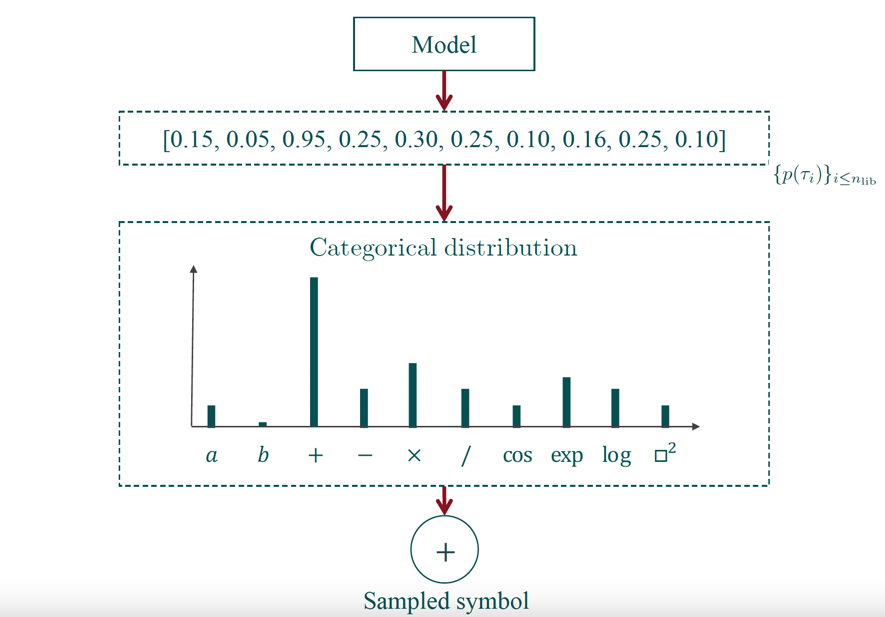

Let's generate a random probability distribution over the vocabulary for one token (but for a whole batch).


In [48]:
# Random probs for next tokens
next_tokens_probs = np.random.random((batch_size, vocab_size))                         # (batch_size, vocab_size)
# Normalize the probabilities so that they sum to 1
next_tokens_probs /= next_tokens_probs.sum(axis=-1, keepdims=True)                     # (batch_size, vocab_size)

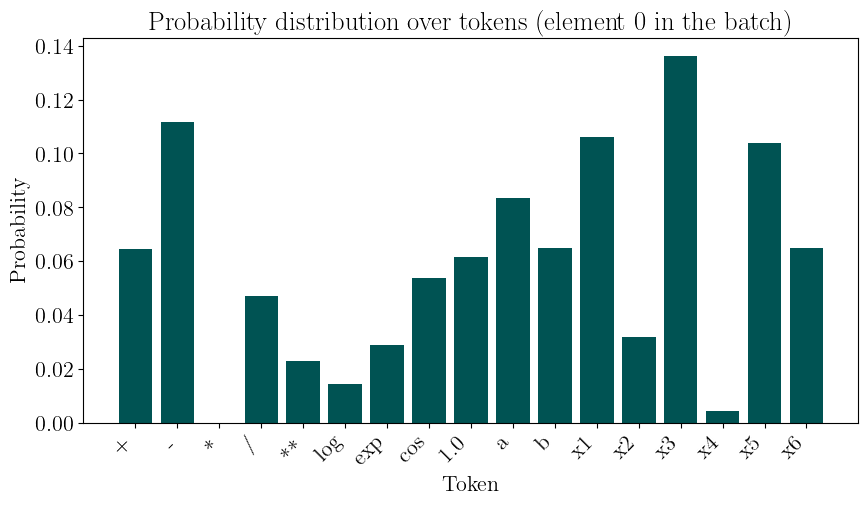

In [49]:
# Showing distribution for i_expr element in the batch, using my_library.names as x-axis labels
i_expr = 0
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(np.arange(vocab_size), next_tokens_probs[i_expr], color="#005353")
ax.set_xticks(np.arange(vocab_size))
ax.set_xticklabels(my_library.choosable_sympy_repr, rotation=45, ha="right")
ax.set_title(f"Probability distribution over tokens (element {i_expr} in the batch)")
ax.set_xlabel("Token")
ax.set_ylabel("Probability")
plt.show()

Let's sample one token from this distribution (but for a whole batch).

In [50]:
# These probabilities could come from a statistical model such as a neural network, or any other source:
next_tokens_probs = torch.tensor(next_tokens_probs)                                     # (batch_size, vocab_size)
next_tokens_idx   = torch.multinomial(next_tokens_probs, num_samples=1).squeeze(-1)     # (batch_size,)
next_tokens_names = my_library.choosable_names[next_tokens_idx]                         # (batch_size,)

In [51]:
# Showing sampled token name for first element in the batch
print(f"Sampled token name for element {i_expr} in the batch: {next_tokens_names[0]}")

Sampled token name for element 0 in the batch: add


### Sampling a sequence of tokens i.e. an expression

Let's generate a sequence of tokens (an expression) by sampling one token at a time, while ensuring that the generated expression is valid by construction.

#### Initializing the batch of expressions

Let's first define the maximum length of the expression we want to generate:

In [52]:
max_length = 50

Let's initialize our batch of expressions as empty:

In [53]:
my_expressions = physo.toolkit.get_expressions(
    batch_size = batch_size,
    max_length = max_length,
    library    = my_library,)
print(my_expressions)

[['◻️' '-' '-' ... '-' '-' '-']
 ['◻️' '-' '-' ... '-' '-' '-']
 ['◻️' '-' '-' ... '-' '-' '-']
 ...
 ['◻️' '-' '-' ... '-' '-' '-']
 ['◻️' '-' '-' ... '-' '-' '-']
 ['◻️' '-' '-' ... '-' '-' '-']]


#### Priors

In order to ensure that the generated expression is valid, we will use priors that are computed after each token generation. These priors can be used to bias the search towards certain expressions.




Only one of those prior is essential : the `HardLengthPrior` which ensures that the expression reaches mathematical validity before the maximum number of tokens is reached. This is essential to ensure that the expression is valid and can be decoded back to its symbolic form.

In [54]:
priors_config = [
        # Hard length prior: all expressions must have a length between min_length and max_length.
        ("HardLengthPrior"  , {"min_length": 4, "max_length": max_length, }),
    ]

However, it is recommended to also use a `SoftLengthPrior` which biases the search expressions to have a length around a certain value, with a certain scale (gaussian prior). This is useful to avoid relying on the `HardLengthPrior` alone which is a hard constraint on the statistical model severely limiting its ability to freely generate expressions potentially leading to suboptimal expressions.

In [55]:
priors_config += [
        # Soft length prior: expressions should have a length around length_loc, with a scale of scale (gaussian prior).
        ("SoftLengthPrior"  , {"length_loc": 20, "scale": 5, }),
                        ]

`physo` also includes many other priors that can be used to bias the search towards certain expressions. See [priors doc](https://physo.readthedocs.io/en/latest/r_features.html#priors) for a description of all available priors. Here we will use the following priors:

In [56]:
priors_config += [
    # Uniform probability distribution over tokens by their arities.
    ("UniformArityPrior", None),
    # Avoiding eg. log(exp(...)) or sqrt((...)^2)
    ("NoUselessInversePrior"  , None),
    # Enforcing dimensional analysis with escape for probs < float epsilon.
    # ("PhysicalUnitsPrior", {"prob_eps": np.finfo(np.float32).eps}),
    # Avoiding eg. exp(...+exp(...)) or log(log(...)) etc.
    ("NestedFunctions", {"functions":["exp",], "max_nesting" : 1}),
    ("NestedFunctions", {"functions":["log",], "max_nesting" : 1}),
    # Avoiding eg. sin(...*cos(...)) or cos(sin(...)) etc.
    ("NestedTrigonometryPrior", {"max_nesting" : 1}),
    # Avoiding 1. appearing more than 3 times in an expression.
    ("OccurrencesPrior", {"targets" : ["1.0",], "max" : [3,] }),
]

Let's get our combined prior for this batch of expressions:

In [57]:
prior = physo.toolkit.get_prior(priors_config = priors_config,
                                  max_length  = max_length,
                                  expressions = my_expressions,
                                  library     = my_library,)

In [58]:
print(prior)

PriorCollection:
- HardLengthPrior (min_length = 4, max_length = 50)
- SoftLengthPrior (length_loc = 20, scale = 5)
- UniformArityPrior
- NoUselessInversePrior (['log', 'exp'] can not be child of ['exp', 'log'])
- NestedFunctions (tokens = ['exp'], nesting forbidden)
- NestedFunctions (tokens = ['log'], nesting forbidden)
- NestedTrigonometryPrior (tokens = ['cos'], nesting forbidden)
- OccurrencesPrior (tokens ['1.0'] can be used [3] times max)


`physo` also includes a dimensional analysis module that can be used to ensure that the generated expressions are dimensionally consistent. You can use it by adding the `PhysicalUnitsPrior` to the `priors_config` list above and specifying units for the variables and constants in the library. See the [demo_random_sampler notebook](https://github.com/WassimTenachi/PhySO/blob/main/demos/toolkit/demo_random_sampler.ipynb) to see how to pass units of variables and constants or the [dimensional analysis doc](https://physo.readthedocs.io/en/latest/r_features.html#dimensional-analysis) for more details.

#### Decoding loop 👇

The following loop will sample one token at a time from a probability distribution over the vocabulary, while ensuring that the generated expression is valid by construction by applying the priors defined above.

Note that the embedding is fairly fast and that computational time in the following cell is dominated by the printing of the expressions (using sympy), which is not necessary for the generation itself. You can remove the printing to speed up the generation process or use the more efficient `get_infix_str` method instead of `get_infix_pretty`.


In [59]:
print("Token '%s' indicates parts of the expressions that are not yet filled in."%physo.physym.token.DUMMY_TOKEN_NAME)

Token '◻️' indicates parts of the expressions that are not yet filled in.


In [60]:
# -- Showing progress --
print("-------------")
print("🏗Step %i/%i"%(0, max_length))
print(my_expressions.get_infix_pretty(i_expr))

for step in range(max_length):

        # -- Sampling next token from model --
        # 👇 Insert your ML model here 👇
        outlogit = np.random.random((batch_size, vocab_size))                                # (batch_size, vocab_size)
        # Here we sample our probability distribution for the next tokens from a random distribution, but you can replace this with your own model's output.
        outlogit = torch.tensor(outlogit)                                                    # (batch_size, vocab_size)

        # -- Prior --
        # Getting prior probabilities for the next tokens
        prior_array = prior().astype(np.float32)                                             # (batch_size, vocab_size)
        # 0 protection so there is always something to sample -> rarely necessary but useful for numerical stability
        epsilon = 0  # np.finfo(np.float32)
        prior_array[prior_array == 0] = epsilon
        is_able_to_sample = (prior_array.sum(axis=-1) > 0.)  # (batch_size,)
        assert is_able_to_sample.all(), "❌ Prior(s) make it impossible to successfully sample expression(s) as all " \
                                        "choosable tokens have 0 prob for %i/%i programs." % (is_able_to_sample.sum(),
                                                                                              batch_size)
        prior_array = torch.tensor(prior_array,
                        # no need to backpropagate through the prior as it is deterministic
                        requires_grad=False)                                                   # (batch_size, vocab_size)
        logprior = torch.log(prior_array)                                                      # (batch_size, vocab_size)

        # -- Combining logit and prior --
        logit           = outlogit + logprior                                                  # (batch_size, vocab_size)
        next_tokens_idx = torch.multinomial(torch.exp(logit),                                  # (batch_size,)
                                       num_samples=1)[:, 0]

        # -- Updating expressions --
        next_tokens_idx = next_tokens_idx.cpu().detach().numpy()
        my_expressions.append(next_tokens_idx)

        # -- Showing progress for one element of the batch --
        print("-------------")
        print("🏗Step %i/%i"%(step+1, max_length))
        next_tokens_names = my_library.choosable_names[next_tokens_idx]
        i_expr = 0
        if my_expressions.is_complete[i_expr]:
            print(f" ✅Expression no {i_expr} has reached completeness, ignoring new token.")
        else:
            print(f" ✏️️Adding token '{next_tokens_names[i_expr]}' to expression no {i_expr} in the batch.")
        print(my_expressions.get_infix_pretty(i_expr))


-------------
🏗Step 0/50
◻️
-------------
🏗Step 1/50
 ✏️️Adding token 'exp' to expression no 0 in the batch.
 ◻️
ℯ  
-------------
🏗Step 2/50
 ✏️️Adding token 'pow' to expression no 0 in the batch.
 ⎛  ◻️⎞
 ⎝◻️  ⎠
ℯ      
-------------
🏗Step 3/50
 ✏️️Adding token 'log' to expression no 0 in the batch.
    ◻️    
 log  (◻️)
ℯ         
-------------
🏗Step 4/50
 ✏️️Adding token 'pow' to expression no 0 in the batch.
    ◻️⎛  ◻️⎞
 log  ⎝◻️  ⎠
ℯ           
-------------
🏗Step 5/50
 ✏️️Adding token 'x4' to expression no 0 in the batch.
    ◻️⎛  ◻️⎞
 log  ⎝x₄  ⎠
ℯ           
-------------
🏗Step 6/50
 ✏️️Adding token 'add' to expression no 0 in the batch.
    ◻️⎛  2⋅◻️⎞
 log  ⎝x₄    ⎠
ℯ             
-------------
🏗Step 7/50
 ✏️️Adding token 'x5' to expression no 0 in the batch.
    ◻️⎛  x₅ + ◻️⎞
 log  ⎝x₄       ⎠
ℯ                
-------------
🏗Step 8/50
 ✏️️Adding token 'x4' to expression no 0 in the batch.
    ◻️⎛  x₄ + x₅⎞
 log  ⎝x₄       ⎠
ℯ                
-------------
🏗Step 9/50
 ✏️️Ad

## Manipulating expressions

Now that we have generated our expressions, you may want to evaluate them, export them, explore their properties etc to build your own reward signal for your generative model. `physo` provides many tools to manipulate expressions that are detailed in the [demo_expressions](https://github.com/WassimTenachi/PhySO/blob/dev-enc/demos/toolkit/demo_expressions.ipynb) which is complementary to this notebook.